<a href="https://colab.research.google.com/github/Dromarion/Dog-Breed-Classification-Model/blob/main/dog_vision_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification Model Experiments
This notebook will be used for testing various experiments to create a multi-class image classifier using Tensorflow.

## Objectives
If I take a photo of a dog, I want to know what breed the dog is.

## Data
The data used for this project will be from Kaggle's dog breed identification dataset. This should be stored in the google drive inside 

/<wbr>content/drive/MyDrive/Data/Dog Vision/

https://www.kaggle.com/c/dog-breed-identification/data

## Features
* There are 120 unique breeds of dogs, some notable breeds seem to be missing, for example Huskies.
* There are 10,000+ images in each of the training and test datasets. The training images have labels while the test datasets do not.

In [2]:
# Import Libraries
import os
import datetime
from IPython.display import Image
# Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
# Create variables for training labels and filepaths
labels_csv = pd.read_csv("/content/drive/MyDrive/Data/Dog Vision/labels.csv")
filepath = ["/content/drive/MyDrive/Data/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
# Verify if filepaths match actual number of files in directory
len(filepath) == len(os.listdir("/content/drive/MyDrive/Data/Dog Vision/train/"))

True

In [135]:
# Create array of all breed labels in csv
labels = labels_csv["breed"].to_numpy()
# Create array of the 120 unique breeds
unique_breeds = np.unique(labels)
# Turn each label into a series of booleans of all 120 unique breeds
boolean_labels = [label == unique_breeds for label in labels]

### Create Validation Set

In [136]:
# Set X/y Variables
X = filepath
y = boolean_labels

In [137]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [138]:
#Split the data
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)


In [139]:
# Preprocess images
IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
  """
  Preprocesses an image into a tensor from the image path
  """
  # Read in an image path
  image = tf.io.read_file(image_path)
  # Turn image into numerical tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert color channels from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image to IMG_SIZE value
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [140]:
# Function to create a simple tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image pathname and processes the image, returns the processed image and the label
  """
  image = process_image(image_path)
  return image, label

In [141]:
# Define Batch Size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image(X) and label(y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test data set, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch 
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y)))# labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
  else: 
    print("Creating training data batches...")
    # Turn filepaths and labels into tensors    
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))
    # Create (image,label) tuples (this also turns the  image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)       
  return data_batch                           

In [142]:
# Create training and validation batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


# Visualization

In [159]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup a figure
  plt.figure(figsize=(12,12))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots(5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()].replace("_"," ").title())
    # Turn grid lines off
    plt.axis("off")

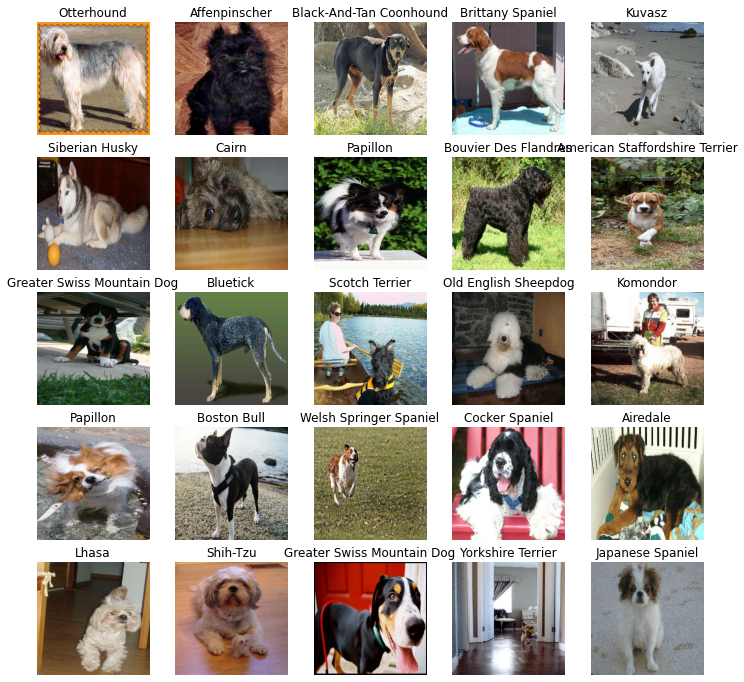

In [160]:
# Visualization
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

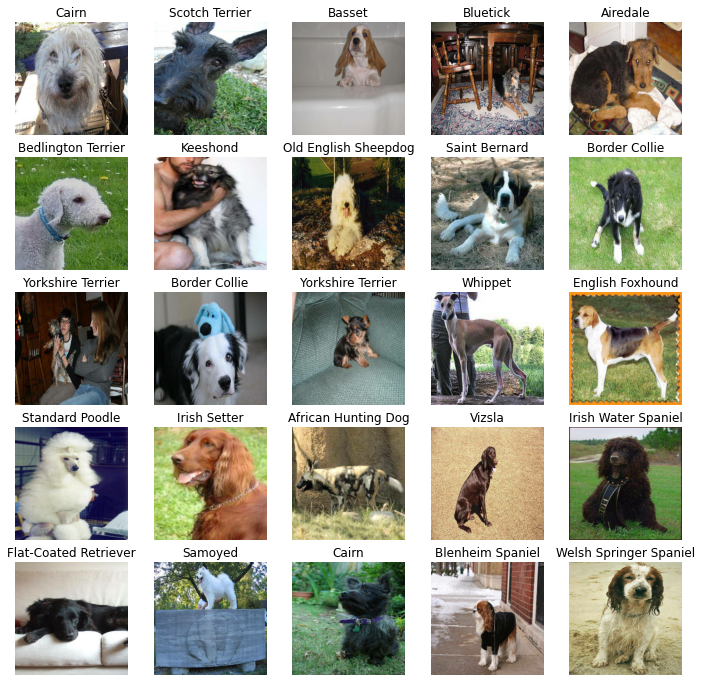

In [161]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)